In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import datetime
from IPython.display import display

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore")

# LOAD DATA FROM CSV FILE

In [2]:
def load_data(csv_path):
    return pd.read_csv(csv_path)


target_col = "amount"
date = "txn_date"

sales_data = load_data("supervised_model.csv")
sales_data.head()

,txn_date,is_stationary,amount,amount_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13
0,2020-07-27,False,3433.5,3433.5,3433.5,2197.5,2300.5,2644.5,2431.75,3362.25,3033.00,2955.50,2001.05,2423.30,2977.80,3000.00,2780.80
1,2020-07-28,False,1990.0,1990.0,1990.0,3433.5,2197.5,2300.5,2644.50,2431.75,3362.25,3033.00,2955.50,2001.05,2423.30,2977.80,3000.00
2,2020-07-29,False,1897.5,1897.5,1897.5,1990.0,3433.5,2197.5,2300.50,2644.50,2431.75,3362.25,3033.00,2955.50,2001.05,2423.30,2977.80
3,2020-07-30,False,3244.5,3244.5,3244.5,1897.5,1990.0,3433.5,2197.50,2300.50,2644.50,2431.75,3362.25,3033.00,2955.50,2001.05,2423.30
4,2020-07-31,False,3225.0,3225.0,3225.0,3244.5,1897.5,1990.0,3433.50,2197.50,2300.50,2644.50,2431.75,3362.25,3033.00,2955.50,2001.05


# FEATURE ENGINEERING

In [3]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280 entries, 0 to 279
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   txn_date       280 non-null    object 
 1   is_stationary  280 non-null    bool   
 2   amount         280 non-null    float64
 3   amount_diff    280 non-null    float64
 4   lag_1          280 non-null    float64
 5   lag_2          280 non-null    float64
 6   lag_3          280 non-null    float64
 7   lag_4          280 non-null    float64
 8   lag_5          280 non-null    float64
 9   lag_6          280 non-null    float64
 10  lag_7          280 non-null    float64
 11  lag_8          280 non-null    float64
 12  lag_9          280 non-null    float64
 13  lag_10         280 non-null    float64
 14  lag_11         280 non-null    float64
 15  lag_12         280 non-null    float64
 16  lag_13         280 non-null    float64
dtypes: bool(1), float64(15), object(1)
memory usage: 35.4+

In [4]:
# transform uppercase columns name to lowercase
sales_data.columns = sales_data.columns.str.lower()

# convert str date to datatime
sales_data[date] = pd.to_datetime(sales_data[date])

# remove all object columns
sales_data = sales_data.select_dtypes(exclude=['object'])

# resample sales
sales_data.set_index([date], inplace=True)
sales_data = sales_data.resample("D").sum()

# handle null values
def handle_missing_values(df, threshold=0.7):
    df = df[df.columns[df.isna().mean() < threshold]]
    df = df.loc[df.isna().mean(axis=1) < threshold]
    
    df = df.fillna(0)
    
    return df

def handle_outliers(df, target_col, upper_limit=0.95, lower_limit=0.5):
    upper_lim = df[target_col].quantile(upper_limit)
    lower_lim = df[target_col].quantile(lower_limit)

    print(f"upper limit {upper_lim} vs lower limit {lower_lim}")
    df = df[(df[target_col] < upper_lim) & (df[target_col] > lower_lim)]
    
    return df

sales_data = handle_missing_values(df=sales_data)
sales_data = handle_outliers(df=sales_data, target_col=target_col)
sales_data.info()

upper limit 3419.05 vs lower limit 2399.125
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 126 entries, 2020-07-30 to 2021-04-30
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   is_stationary  126 non-null    int64  
 1   amount         126 non-null    float64
 2   amount_diff    126 non-null    float64
 3   lag_1          126 non-null    float64
 4   lag_2          126 non-null    float64
 5   lag_3          126 non-null    float64
 6   lag_4          126 non-null    float64
 7   lag_5          126 non-null    float64
 8   lag_6          126 non-null    float64
 9   lag_7          126 non-null    float64
 10  lag_8          126 non-null    float64
 11  lag_9          126 non-null    float64
 12  lag_10         126 non-null    float64
 13  lag_11         126 non-null    float64
 14  lag_12         126 non-null    float64
 15  lag_13         126 non-null    float64
dtypes: float64(15), int64(1)
memory usa

# FEATURE IMPORTANCE

In [5]:
def get_numeric_feat(df):
    numeric_feats = df.dtypes[df.dtypes != "datetime64[ns]"].index
    # numeric_feats = df[numeric_feats].dtypes[df.dtypes != "int64"].index
    return numeric_feats

def get_important_feat(df, target_col):
    imp_feats = []
    numeric_feats = get_numeric_feat(df=df)
    
    cormat = df[numeric_feats].corr().fillna(0)

    target_idx = cormat.columns.get_loc(target_col)
    
    for feat in numeric_feats:
        try:
            if cormat[feat][target_idx] > 0.2:
                imp_feats.append(feat)
        except:
            pass


    return df[imp_feats]

imp_sales_data = get_important_feat(df=sales_data, target_col=target_col)
imp_sales_data.head()

,amount,amount_diff,lag_1
txn_date,,,
2020-07-30,3244.50,3244.50,3244.50
2020-07-31,3225.00,3225.00,3225.00
2020-08-01,2413.50,2413.50,2413.50
2020-08-02,3237.00,3237.00,3237.00
2020-08-05,2780.75,2780.75,2780.75


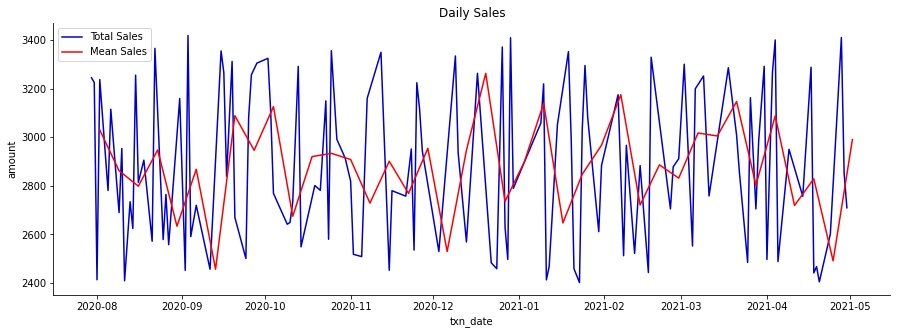

In [6]:
def time_plot(data, x_col, y_col, title, freq="W"):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(x_col, y_col, data=data, ax=ax, color='mediumblue', label='Total Sales')

    second = data.set_index([date]).resample(freq).mean()[y_col].reset_index()
    second[date] = pd.to_datetime(second[date], format=f'%{freq}')
    
    sns.lineplot(second[date], y_col, data=second, ax=ax, color='red', label='Mean Sales')
    
    ax.set(xlabel=x_col, ylabel=y_col, title=title)
    sns.despine()
    
time_plot(imp_sales_data.reset_index(), date, target_col, 'Daily Sales', freq="W")

# CHECK FOR STATIONARITY

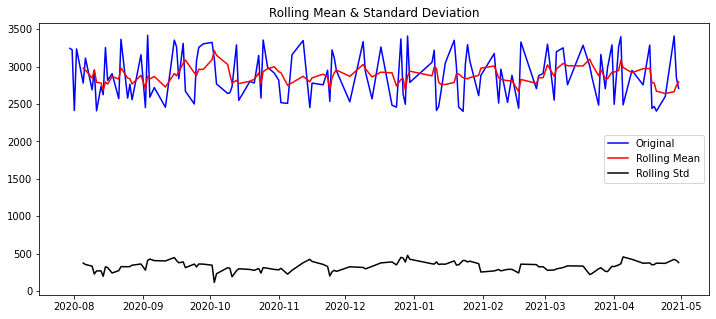

Results of Dickey-Fuller Test:


,0,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Test Statistic,-4.707918,-3.486056,-2.885943,-2.579785
p-value,0.000081,-3.486056,-2.885943,-2.579785
#Lags Used,5.000000,-3.486056,-2.885943,-2.579785
Number of Observations Used,120.000000,-3.486056,-2.885943,-2.579785


False

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()
    
    #Plot rolling statistics:
    plt.figure(figsize=(12, 5))
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    
    dfoutput = pd.DataFrame(dftest[:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    display(dfoutput)
    
    return False if dftest[1] < 0.5 and dftest[0] < dftest[4]["5%"] else True
    
is_stationary = test_stationarity(imp_sales_data[target_col], 5)
is_stationary

In [8]:
def get_diff(data, target_col, is_stationary):
    if not is_stationary:
        data[f'{target_col}_diff'] = data[target_col].diff()
    else:
        data[f'{target_col}_diff'] = data[target_col]
        
    data = data.dropna()

    return data

,amount,amount_diff,lag_1
txn_date,,,
2020-07-31,3225.00,-19.50,3225.00
2020-08-01,2413.50,-811.50,2413.50
2020-08-02,3237.00,823.50,3237.00
2020-08-05,2780.75,-456.25,2780.75
2020-08-06,3115.05,334.30,3115.05


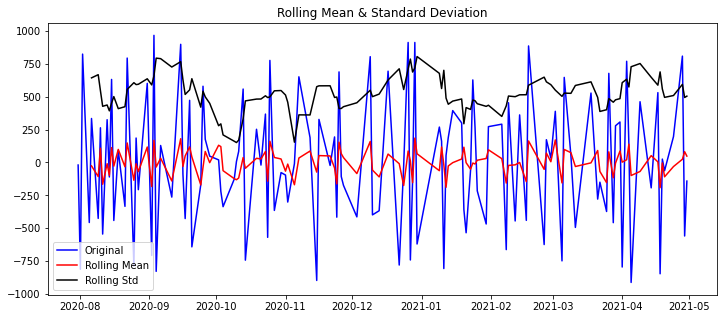

Results of Dickey-Fuller Test:


,0,Critical Value (1%),Critical Value (5%),Critical Value (10%)
Test Statistic,-8.972425e+00,-3.486535,-2.886151,-2.579896
p-value,7.689638e-15,-3.486535,-2.886151,-2.579896
#Lags Used,5.000000e+00,-3.486535,-2.886151,-2.579896
Number of Observations Used,1.190000e+02,-3.486535,-2.886151,-2.579896


False

In [9]:
stationary_df = get_diff(imp_sales_data, target_col=target_col, is_stationary=is_stationary)

stationary_df.to_csv('stationary_df.csv')
display(stationary_df.head())

test_stationarity(stationary_df[target_col + "_diff"], window=5)

# OBSERVING LAGS

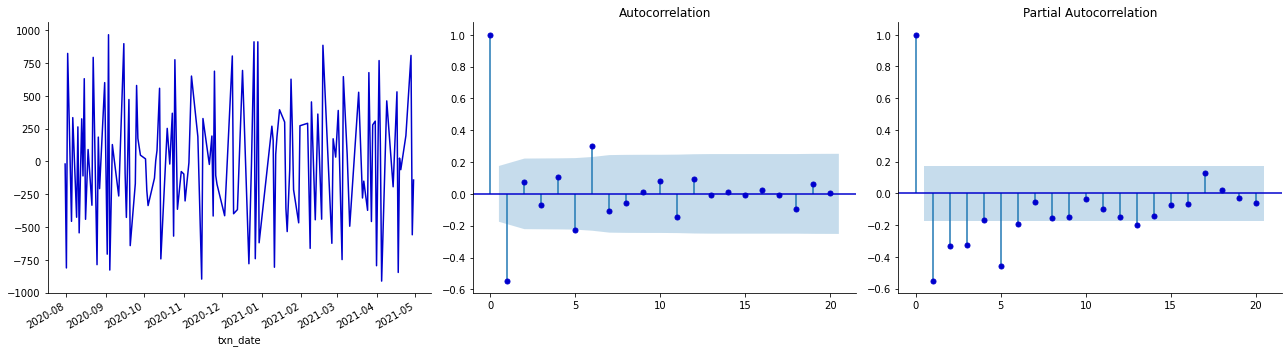

In [10]:
import statsmodels.tsa.api as smt

def plots(data, target_col, lags=None):
    
    # Convert dataframe to datetime index
    dt_data = data[target_col]
    dt_data.dropna(axis=0)
    
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    dt_data.plot(ax=raw, figsize=(18, 5), color='mediumblue')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color='mediumblue')
    sns.despine()
    plt.tight_layout()

plots(stationary_df, target_col=target_col+"_diff", lags=20);

# CREATE THE BASELINE MODEL FOR MODEL TESTING

In [11]:
# nerve, baseline, starting model.
def baseline_model(data, target_col):
    data = data.copy()
    data = data[[target_col]]
    
    data_base = pd.concat([data, data.shift(1)], axis=1).dropna()
    data_base.columns = ["actual", "forecast"]
    
    base_error = mean_squared_error(data_base.actual, data_base.forecast)
    
    print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % base_error}")
    print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(base_error)}")
    print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(data_base.actual, data_base.forecast)}")

baseline_model(stationary_df, target_col=target_col)

MEAN SQUARE ERROR (MSE) 242404.993
ROOT MEAN SQUARE ERROR (RMSE) 492.346
R2_SCORE (ACCURACY) -1.385


# ARIMA AND SARIMA MODEL

In [12]:
import statsmodels.api as sm

In [13]:
from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

stepwise_fit = auto_arima(stationary_df[target_col+"_diff"], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1907.518, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1865.168, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1905.528, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1852.313, Time=0.20 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1841.148, Time=0.14 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=1840.300, Time=0.18 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=1816.861, Time=0.24 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.25 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=1814.937, Time=0.11 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=1838.310, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=1.46 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.52 s

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  125
Model:               SARIMAX(5, 0, 0)   Log Likelihood                -901.469
Date:                Fri, 07 May 2021   AIC                           1814.937
Time:                        03:45:37   BIC                           1831.907
Sample:                             0   HQIC                          1821.831
                                - 125                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9499      0.087    -10.946      0.000      -1.120      -0.780
ar.L2         -0.8490      0.117     -7.245      0.000      -1.079      -0.619
ar.L3         -0.7382      0.122     -6.052      0.000      -0.977      -0.499
ar.L4         -0.5451      0.106     -5.125      0.000      -0.754      -0.337
ar.L5         -0.4387      0.086     -5.110      0.000      -0.607      -0.270
sigma2      1.059e+05   1.97e+04      5.376      0.000    6.73e+04    1.44e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.69   Jarque-Bera (JB):                 4.98
Prob(Q):                              0.41   Prob(JB):                         0.08
Heteroskedasticity (H):               1.18   Skew:                             0.06
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
def arima_model(data, target_col, order):
    data = data.copy()
    data = data[[target_col]]
    
    test_days = 7
    train = data[:-test_days]
    test = data[-test_days:]
    
    model = sm.tsa.ARIMA(train, order=order).fit()    
    test["forecast"] = model.forecast(steps=test_days)[0]
    
    error = mean_squared_error(test[target_col], test.forecast)
    
    # compared with baseline model
    print("BASELINE MODEL")
    baseline_model(stationary_df, target_col=target_col)    
    print("\n")
    print(f"ARIMA AIC {'%.3f' % model.aic}")
    print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
    print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
    print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(test[target_col], test.forecast)}")
    
    print(f"ORDER {order}\n")
    test.plot()
    plt.show()
    
    display(test)
    
# scaler = MinMaxScaler(feature_range=(-1, 1))
# stationary_df[target_col+"_diff"] = scaler.fit_transform(stationary_df[target_col+"_diff"].values.reshape(-1, 1))

# arima_model(stationary_df, target_col=target_col+"_diff", order=(0, 0, 11)) # For NON DIFF DATA (2, 2, 0), For DIFF DATA (0, 0, 11)

In [16]:
def sarima_model(data, target_col, config):
    data = data.copy()
    data = data[[target_col]]
    
    test_days = 7
    train = data[:-test_days]
    test = data[-test_days:]
    
    order, sorder, trend = config
    model = sm.tsa.SARIMAX(train, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False).fit()    
    test["forecast"] = pd.DataFrame(model.predict(start=len(train) + 1, end=len(data), dynamic=test_days), columns=["forecast"]).reset_index(drop=True).values
        
    error = mean_squared_error(test[target_col], test.forecast)
    
    # compared with baseline model
    print("BASELINE MODEL")
    baseline_model(stationary_df, target_col=target_col)    
    print("\n")
    print(f"ARIMA AIC {'%.3f' % model.aic}")
    print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
    print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
    print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(test[target_col], test.forecast)}")
    
    print(f"ORDER {config}\n")
    test.plot()
    plt.show()
    
    display(test)
    
    
# sarima_model(stationary_df, target_col=target_col+"_diff", config=[(8, 0, 1), (0, 0, 0, 0), 'n'])
# For NON DIFF DATA [(0, 2, 6), (0, 0, 0, 0), 'c'], For [(8, 0, 1), (0, 0, 0, 0), 'n'] 

In [17]:
# # SARIMA GRID SEARCH
# # create a set of sarima configs to try
# def sarima_configs(seasonal=[0]):
#     models = list()
#     # define config lists
#     p_params = range(0, 15)
#     d_params = range(0, 3)
#     q_params = range(0, 15)
#     t_params = ['n','c','t','ct']
#     P_params = range(0, 12)
#     D_params = range(0, 3)
#     Q_params = range(0, 12)
#     m_params = seasonal
#     # create config instances
#     for p in p_params:
#         for d in d_params:
#             for q in q_params:
#                 for t in t_params:
#                     for P in P_params:
#                         for D in D_params:
#                             for Q in Q_params:
#                                 for m in m_params:
#                                     cfg = [(p,d,q), (P,D,Q,m), t]
#                                     models.append(cfg)
#     return models

# cfg_list = sarima_configs()

# for cfg in cfg_list:
#     try:
#         sarima_model(stationary_df, target_col=target_col+"_diff", config=cfg)
#     except:
#         continue

In [18]:
stationary_df.head()

,amount,amount_diff,lag_1
txn_date,,,
2020-07-31,3225.00,-19.50,3225.00
2020-08-01,2413.50,-811.50,2413.50
2020-08-02,3237.00,823.50,3237.00
2020-08-05,2780.75,-456.25,2780.75
2020-08-06,3115.05,334.30,3115.05


In [19]:
display(stationary_df.shape)
stationary_df.describe().T

(125, 3)

,count,mean,std,min,25%,50%,75%,max
amount,125.0,2880.6448,320.288950,2402.25,2579.0,2851.25,3199.00,3418.5
amount_diff,125.0,-4.2780,492.330794,-911.70,-413.5,-19.50,327.25,966.0
lag_1,125.0,2880.6448,320.288950,2402.25,2579.0,2851.25,3199.00,3418.5


# LSTM MODEL

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [21]:
stationary_df[target_col+"_diff"] = stationary_df[target_col+"_diff"].values.reshape(-1, 1)
stationary_df.dropna(inplace=True, axis=0)
stationary_df.head()

,amount,amount_diff,lag_1
txn_date,,,
2020-07-31,3225.00,-19.50,3225.00
2020-08-01,2413.50,-811.50,2413.50
2020-08-02,3237.00,823.50,3237.00
2020-08-05,2780.75,-456.25,2780.75
2020-08-06,3115.05,334.30,3115.05


In [22]:
# MULTIVARIANT FORECASTING WITH LSTM
dataset = stationary_df.copy()
dataset.drop([target_col], inplace=True, axis=1)

dataset.dropna(inplace=True)

display(dataset.head())
dataset.info()

,amount_diff,lag_1
txn_date,,
2020-07-31,-19.50,3225.00
2020-08-01,-811.50,2413.50
2020-08-02,823.50,3237.00
2020-08-05,-456.25,2780.75
2020-08-06,334.30,3115.05


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2020-07-31 to 2021-04-30
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount_diff  125 non-null    float64
 1   lag_1        125 non-null    float64
dtypes: float64(2)
memory usage: 2.9 KB


In [23]:
training_set = dataset.copy().values.astype("float")

print("Shape of training set == {}".format(training_set.shape))
display(training_set[:3])

Shape of training set == (125, 2)


array([[ -19.5, 3225. ],
       [-811.5, 2413.5],
       [ 823.5, 3237. ]])

In [24]:
# scale down features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)

scaler_predict = StandardScaler()
scaler_predict = scaler_predict.fit(training_set[:, -1].reshape(-1, 1))

In [25]:
# create a data structure with `look_back` and 1 output
x_train = list()
y_train = list()

n_futures = 1 # #of days we want to predict into the future
look_back = 5 # #of days we want to use to predict the future

for i in range(look_back, len(training_set_scaled) - n_futures + 1):
    if i >= len(training_set_scaled) - 1:
        break
    
    x_train.append(training_set_scaled[i - look_back:i, :])
    y_train.append(training_set_scaled[i + n_futures, :])
    
x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)

x_train.shape, y_train.shape

((119, 5, 2), (238, 1))

In [26]:
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD

In [27]:
%%time

model = Sequential()
model.add(LSTM(units=20, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False))
model.add(Dropout(0.25))

# model.add(LSTM(units=100, return_sequences=False))
# model.add(Dropout(0.25))

model.add(Dense(units=y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.01), loss="mean_squared_error")

es = EarlyStopping(min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(factor=0.5, verbose=1)
# mcp = ModelCheckpoint(filepath="test_118/weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard("test_118/logs")

# model.fit(x_train, y_train, shuffle=False, epochs=80, batch_size=1, callbacks=[es, rlr], validation_split=0.3, verbose=1)

CPU times: user 573 ms, sys: 19.9 ms, total: 593 ms
Wall time: 1.76 s


In [28]:
# make 1 week prediction
datelist_future = pd.date_range(dataset.index[-1], periods=7, freq="1d").tolist()

datelist_future_ = []
for date in datelist_future:
    datelist_future_.append(date.date())
    
datelist_future_

[datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 1),
 datetime.date(2021, 5, 2),
 datetime.date(2021, 5, 3),
 datetime.date(2021, 5, 4),
 datetime.date(2021, 5, 5),
 datetime.date(2021, 5, 6)]

In [29]:
predict_future = model.predict(x_train[-len(datelist_future_):])
predict_future = scaler_predict.inverse_transform(predict_future)
y_train = scaler_predict.inverse_transform(y_train)

BASELINE MODEL
MEAN SQUARE ERROR (MSE) 242404.993
ROOT MEAN SQUARE ERROR (RMSE) 492.346
R2_SCORE (ACCURACY) -1.385


LSTM MODEL
MEAN SQUARE ERROR (MSE) 118237.822
ROOT MEAN SQUARE ERROR (RMSE) 343.857
R2_SCORE (ACCURACY) -0.030


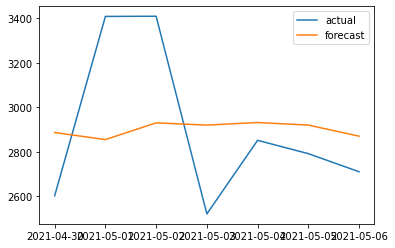

,actual,forecast
2021-04-30,2601.750000,2886.364746
2021-05-01,3409.240093,2854.653809
2021-05-02,3410.000000,2929.939941
2021-05-03,2519.929490,2919.911865
2021-05-04,2851.250000,2931.464844
2021-05-05,2791.374149,2919.924805
2021-05-06,2709.750000,2870.031006


In [30]:
df = pd.DataFrame(np.concatenate([y_train[-len(datelist_future_):], predict_future], axis=1), columns=["actual", "forecast"]).set_index(pd.Series(datelist_future_))
error = mean_squared_error(df.actual, df.forecast)

# compared with baseline model
print("BASELINE MODEL")
baseline_model(stationary_df, target_col=target_col)

print("\n")
print(f"LSTM MODEL")
print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(df.actual, df.forecast)}")

df.plot()
plt.show()

df

In [31]:
# UNIVARIANT FORECAST WITH LSTM

In [32]:
dataset = stationary_df.copy()
dataset = dataset[[target_col + "_diff"]]

display(dataset.head())
dataset.info()

,amount_diff
txn_date,
2020-07-31,-19.50
2020-08-01,-811.50
2020-08-02,823.50
2020-08-05,-456.25
2020-08-06,334.30


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 125 entries, 2020-07-31 to 2021-04-30
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   amount_diff  125 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [33]:
training_set = dataset.copy().values.astype("float")

print("Shape of training set == {}".format(training_set.shape))
display(training_set[:3])

Shape of training set == (125, 1)


array([[ -19.5],
       [-811.5],
       [ 823.5]])

In [34]:
# scale down features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
training_set_scaled = scaler.fit_transform(training_set)

In [35]:
# create a data structure with `look_back` and 1 output
x_train = list()
y_train = list()

n_futures = 1 # #of days we want to predict into the future
look_back = 5 # #of days we want to use to predict the future

for i in range(look_back, len(training_set_scaled) - n_futures + 1):
    if i >= len(training_set_scaled) - 1:
        break
    
    x_train.append(training_set_scaled[i - look_back:i])
    y_train.append(training_set_scaled[i + n_futures])
    
x_train, y_train = np.array(x_train), np.array(y_train).reshape(-1, 1)

x_train.shape, y_train.shape

((119, 5, 1), (119, 1))

In [36]:
%%time

# model = Sequential()
# model.add(LSTM(units=50, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
# model.add(Dropout(0.25))

# model.add(LSTM(units=100, return_sequences=False))
# model.add(Dropout(0.25))

# model.add(Dense(units=y_train.shape[1]))

model = Sequential()
model.add(LSTM(20, batch_input_shape=(1, x_train.shape[1], x_train.shape[2]), stateful=True))
model.add(Dense(1))
model.add(Dense(y_train.shape[1]))

model.compile(optimizer=Adam(learning_rate=0.1), loss="mean_squared_error")

es = EarlyStopping(min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(factor=0.5, verbose=1)
# mcp = ModelCheckpoint(filepath="test_118/weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
# tb = TensorBoard("test_118/logs")

# history = model.fit(x_train, y_train, shuffle=False, epochs=80, batch_size=1, callbacks=[es, rlr], validation_split=0.2, verbose=1)

CPU times: user 409 ms, sys: 3.77 ms, total: 413 ms
Wall time: 456 ms


In [37]:
# his = history.history
# plt.plot(his["loss"], label="loss")
# plt.plot(his["val_loss"], "r", label="val_loss")
# plt.legend()
# plt.title("Training Loss")

# plt.show()

In [38]:
# make 1 week prediction
datelist_future = pd.date_range(dataset.index[-1], periods=7, freq="1d").tolist()

datelist_future_ = []
for date in datelist_future:
    datelist_future_.append(date.date())
    
datelist_future_

[datetime.date(2021, 4, 30),
 datetime.date(2021, 5, 1),
 datetime.date(2021, 5, 2),
 datetime.date(2021, 5, 3),
 datetime.date(2021, 5, 4),
 datetime.date(2021, 5, 5),
 datetime.date(2021, 5, 6)]

In [39]:
predict_future = model.predict(x_train[-len(datelist_future_):], batch_size=1)
predict_future = scaler_predict.inverse_transform(predict_future)
y_train = scaler_predict.inverse_transform(y_train)

BASELINE MODEL
MEAN SQUARE ERROR (MSE) 242404.993
ROOT MEAN SQUARE ERROR (RMSE) 492.346
R2_SCORE (ACCURACY) -1.385


LSTM MODEL
MEAN SQUARE ERROR (MSE) 102464.158
ROOT MEAN SQUARE ERROR (RMSE) 320.100
R2_SCORE (ACCURACY) 0.001


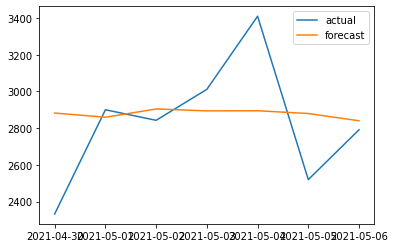

,actual,forecast
2021-04-30,2333.219803,2882.346924
2021-05-01,2900.179708,2859.339355
2021-05-02,2842.768105,2904.611084
2021-05-03,3011.262213,2894.125732
2021-05-04,3409.240093,2894.780029
2021-05-05,2519.929490,2879.700928
2021-05-06,2791.374149,2840.266113


In [40]:
df = pd.DataFrame(np.concatenate([y_train[-len(datelist_future_):], predict_future], axis=1), columns=["actual", "forecast"]).set_index(pd.Series(datelist_future_))
error = mean_squared_error(df.actual, df.forecast)

# compared with baseline model
print("BASELINE MODEL")
baseline_model(stationary_df, target_col=target_col)

print("\n")
print(f"LSTM MODEL")
print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(df.actual, df.forecast)}")

df.plot()
plt.show()

df

In [41]:
stationary_df.head()

,amount,amount_diff,lag_1
txn_date,,,
2020-07-31,3225.00,-19.50,3225.00
2020-08-01,2413.50,-811.50,2413.50
2020-08-02,3237.00,823.50,3237.00
2020-08-05,2780.75,-456.25,2780.75
2020-08-06,3115.05,334.30,3115.05


In [42]:
#create dataframe for transformation from time series to supervised
def generate_supervised(data, target_col):
    supervised_df = data.copy()
    
    #create column for each lag
    for i in range(1, 12): # for daily data we either shift 1 week or 1 month
        col_name = 'lag_' + str(i)
        supervised_df[col_name] = supervised_df[target_col].shift(i)
    
    #drop null values
    supervised_df = supervised_df.dropna().reset_index(drop=True)    
    return supervised_df


model_df = generate_supervised(stationary_df[[target_col, target_col + "_diff"]], target_col + "_diff")
display(model_df.shape)
model_df.head()

(114, 13)

,amount,amount_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11
0,2814.50,-440.75,631.00,-110.25,325.00,-544.05,263.55,-425.05,334.30,-456.25,823.50,-811.50,-19.50
1,2905.55,91.05,-440.75,631.00,-110.25,325.00,-544.05,263.55,-425.05,334.30,-456.25,823.50,-811.50
2,2572.05,-333.50,91.05,-440.75,631.00,-110.25,325.00,-544.05,263.55,-425.05,334.30,-456.25,823.50
3,3365.50,793.45,-333.50,91.05,-440.75,631.00,-110.25,325.00,-544.05,263.55,-425.05,334.30,-456.25
4,2579.00,-786.50,793.45,-333.50,91.05,-440.75,631.00,-110.25,325.00,-544.05,263.55,-425.05,334.30


In [43]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

def undo_scaling(y_pred, x_test, scaler_obj):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0, len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

def predict_df(unscaled_predictions, original_df, target_col, is_stationary):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-len(unscaled_predictions):].index)
    act_sales = list(original_df[-len(unscaled_predictions):][target_col])        
    
    for index in range(0, len(unscaled_predictions)):
        result_dict = {}
        
        if not is_stationary:
            result_dict['forecast'] = unscaled_predictions[index][0] + act_sales[index]
        else:
            result_dict['forecast'] = unscaled_predictions[index][0]
          
        result_dict[date] = sales_dates[index]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [45]:
import tensorflow as tf

In [ ]:
def tts(data, target_col):
    data = data.drop([target_col],axis=1)
    train, test = data[0:-7].values, data[-7:].values
    
    return train, test

train, test = tts(model_df, target_col=target_col)
X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)


X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential()
model.add(LSTM(20, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), stateful=True, return_sequences=True))
model.add(LSTM(100))

model.add(Dropout(0.25))
model.add(Dense(150))
model.add(Dense(y_train.shape[1]))

weight_path = "test_119/weights.h5"
model_path = "test_119/"
mcp = ModelCheckpoint(filepath=weight_path, verbose=1, save_best_only=True, save_weights_only=True)


if not tf.io.gfile.exists(model_path):
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
else:
    model = tf.keras.models.load_model(model_path)
    model.load_weights(weight_path)

model.fit(X_train, y_train, epochs=800, batch_size=1, verbose=1, shuffle=False, validation_split=0.2, callbacks=[mcp, rlr])
model.save(model_path)

Epoch 1/800
82/85 [===========================>..] - ETA: 0s - loss: 0.2643
Epoch 00001: val_loss improved from inf to 0.24130, saving model to test_119/weights.h5
85/85 [==============================] - 3s 32ms/step - loss: 0.2734 - val_loss: 0.2413 - lr: 0.0100
Epoch 2/800
82/85 [===========================>..] - ETA: 0s - loss: 0.2439
Epoch 00002: val_loss did not improve from 0.24130
85/85 [==============================] - 1s 14ms/step - loss: 0.2521 - val_loss: 0.2421 - lr: 0.0100
Epoch 3/800
82/85 [===========================>..] - ETA: 0s - loss: 0.2223
Epoch 00003: val_loss did not improve from 0.24130
85/85 [==============================] - 1s 12ms/step - loss: 0.2293 - val_loss: 0.2510 - lr: 0.0100
Epoch 4/800
78/85 [==========================>...] - ETA: 0s - loss: 0.2553
Epoch 00004: val_loss did not improve from 0.24130
85/85 [==============================] - 1s 10ms/step - loss: 0.2619 - val_loss: 0.2532 - lr: 0.0100
Epoch 5/800
82/85 [===========================>..] 

In [1]:
predictions = model.predict(X_test, batch_size=1)
unscaled = undo_scaling(y_pred=predictions, x_test=X_test, scaler_obj=scaler)

dates = predict_df(unscaled, imp_sales_data, target_col=target_col, is_stationary=is_stationary)[date]
y_test = undo_scaling(y_pred=y_test, x_test=X_test, scaler_obj=scaler)[:, 0]

df = pd.DataFrame(np.concatenate([y_test.reshape(-1, 1), unscaled[:, 0].reshape(-1, 1)], axis=1), columns=["actual", "forecast"]).set_index(pd.Series(dates))
error = mean_squared_error(df.actual, df.forecast)

# compared with baseline model
print("BASELINE MODEL")
baseline_model(stationary_df, target_col=target_col)

print("\n")
print(f"LSTM MODEL")
print(f"MEAN SQUARE ERROR (MSE) {'%.3f' % error}")
print(f"ROOT MEAN SQUARE ERROR (RMSE) {'%.3f' % np.sqrt(error)}")
print(f"R2_SCORE (ACCURACY) {'%.3f' % r2_score(df.actual, df.forecast)}")

df.plot()
plt.show()

df

NameError: name 'model' is not defined